Authur : Farzaneh Zohrabi

In [1]:
# all imports
import sys
sys.path.append('/home/idies/workspace/Storage/fzohrabi/persistent/hrpo-pipeline/')
import plateSolve
from astropy.nddata import CCDData
import ccdproc as ccdp
import os
from pathlib import Path
import warnings
warnings.simplefilter("ignore")
import os
import sys
import numpy as np
import ccdproc as ccdp
import astropy.units as u
import aperturePhot as ap
from astropy.nddata import CCDData
import matplotlib.pyplot as plt
from astropy.io import fits
import itertools
import gain_calculator as gc
import plateSolve


In [2]:
sys.path.append('/home/idies/workspace/Storage/fzohrabi/persistent/hrpo-pipeline')

base = "/home/idies/workspace/"
data_dir = "Temporary/fzohrabi/scratch/20221117"
path = os.path.join(base, data_dir)

os.chdir(path)
if os.path.exists("reduced") == False:
    os.mkdir("reduced")
images = ccdp.ImageFileCollection(path)
#images.summary

3. Reduction Preparation: Make master bias

Use *images.filter* to get only the images with *imagetyp="Bias Frame"*.

Create a master bias frame with *ccdp.combine* on your list of bias frames. Use the median method and specify that *unit="adu"*. I will refer to this master bias frame as *mbias*

Save the master bias with *mbias.write* to "reduced/mbias.fit", flag write to *overwrite=True* in case we rerun this entire script on this same directory multiple times.

`
biases = images.filter( ... )
mbias = ccdp.combine(biases, ... )
mbias.write( ...)
`

In [3]:
biases = images.files_filtered(imagetyp = "Bias Frame", naxis1=1024)
mbias = ccdp.combine(biases, method='median', unit='adu')
mbias.write("reduced/mbias.fit", overwrite = True)

In [4]:
biases = images.filter(imagetyp = "Bias Frame", naxis1=1024)


B1= []
B2= []
i = 0


for ccd in biases.ccds(ccd_kwargs = {"unit":"adu"}): 
    if i % 2 == 0: 
        B1.append(np.ndarray.astype(ccd.data, dtype = np.float64))
    if i % 2 == 1:
        B2.append(np.ndarray.astype(ccd.data, dtype = np.float64))
    i = i + 1 
    


if len(B1) != len(B2): 
    del B1[-1] 



In [5]:
mbiasimage = CCDData.read("reduced/mbias.fit")
#ap.showimage(mbiasimage)

In [6]:

darks = images.filter(imagetyp = "Dark Frame", naxis1=1024)

exptimes = []
red_darks = []

for dark in darks.ccds(ccd_kwargs = {"unit":"adu"}):
    ccd = ccdp.subtract_bias(dark, mbias)
    red_darks.append(ccd)
    exptimes.append(ccd.header["exptime"])
exptimes = np.array(exptimes)
mdark = ccdp.combine (red_darks, method='median', scale=1/exptimes, unit='adu')
mdark.header["exptime"] = 1
mdark.header["exposure"] = 1

mdark.write("reduced/mdark.fit", overwrite = True)

In [7]:
mdarkimage = CCDData.read("reduced/mdark.fit")
#darkimage = CCDData.read("/home/idies/workspace/Temporary/fzohrabi/scratch/20221011/Darks-003.fit", unit="adu")



#strd_dark_raw = ccdp.sigma_func(darkimage,  axis=None)
strd_mdark = ccdp.sigma_func(mdarkimage,  axis=None)

#print ("raw_strddark=",strd_dark_raw)
print ("reduced_strdmdark=",strd_mdark)


#ap.showimage(mdarkimage)
#ap.showimage(darkimage)


reduced_strdmdark= 0.14826022185056018


In [8]:
filters = ["Bessel B", "Bessel V", "Bessel R"]
mflats = {}
F1 = [[],[],[]]
F2 = [[],[],[]]

for filt in filters:
    flats = images.filter(imagetyp="Flat Field", filter=filt) # Get flat images
    j = 0
    i=0
    for flat, fname in flats.ccds(ccd_kwargs={'unit':'adu'}, return_fname = True): # Cycle through ccds
        if fname.startswith('dome'):
            if j % 2 == 0:
                F1[i].append(np.ndarray.astype(flat.data, dtype = np.float64))
            if j % 2 == 1:
                F2[i].append(np.ndarray.astype(flat.data, dtype = np.float64))
            j = j + 1 
    if len(F1[i]) != len(F2[i]): 
        del F1[i][-1] 
    i = i + 1 
#print(F1, F2)

ImageFileCollection(location='', keywords=['simple', 'bitpix', 'naxis', 'naxis1', 'naxis2', 'bscale', 'bzero', 'date-obs', 'exptime', 'exposure', 'set-temp', 'ccd-temp', 'xpixsz', 'ypixsz', 'xbinning', 'ybinning', 'xorgsubf', 'yorgsubf', 'readoutm', 'filter', 'imagetyp', 'focuspos', 'focustem', 'object', 'objctra', 'objctdec', 'objctalt', 'objctaz', 'objctha', 'sitelat', 'sitelong', 'jd', 'jd-helio', 'airmass', 'focallen', 'aptdia', 'aptarea', 'swcreate', 'sbstdver', 'telescop', 'instrume', 'observer', 'notes', 'unit', 'flipstat', 'swowner'], filenames=['/home/idies/workspace/Temporary/fzohrabi/scratch/20221117/domeFlat-001B.fit', '/home/idies/workspace/Temporary/fzohrabi/scratch/20221117/domeFlat-002B.fit', '/home/idies/workspace/Temporary/fzohrabi/scratch/20221117/domeFlat-003B.fit', '/home/idies/workspace/Temporary/fzohrabi/scratch/20221117/domeFlat-004B.fit', '/home/idies/workspace/Temporary/fzohrabi/scratch/20221117/domeFlat-005B.fit'])
ImageFileCollection(location='', keywords=['

In [10]:
#mflatsimage = CCDData.read("/home/idies/workspace/Temporary/fzohrabi/scratch/20221006/reduced/mflats.fit")
#flatimage = CCDData.read("/home/idies/workspace/Temporary/fzohrabi/scratch/20221006/DomeFlat-001R.fit", unit="adu")


#strd_mflat = ccdp.sigma_func(mflatsimage,  axis=None)
#strd_flat_raw = ccdp.sigma_func(flatimage,  axis=None)

#print ("raw_strdflat=",strd_flat_raw)
#print ("reduced_strdmflat=",strd_mflat)

#ap.showimage(mflatsimage)
#ap.showimage(flatimage)


In [ ]:
for filt in filters:
    flats = images.filter(imagetyp = "Flat Field", filter = filt)
    print(flats)
    red_flats = []

    for flat, fname in flats.ccds(ccd_kwargs = {"unit":"adu"}, return_fname = True):
        if fname.startswith('dome'):
            flat = ccdp.subtract_bias(flat, mbias)
            flat = ccdp.subtract_dark(flat, mdark, scale=True, exposure_unit = u.s, exposure_time = 'exptime')
            red_flats.append(flat)
    #print (red_flats)
    filt_string = filt.replace(" ", "_")
    fname = filt_string + "flat.fit"
    mflat = ccdp.combine(red_flats, method='median')
    mflat.write("reduced/mflat.fit" , overwrite = True)
    mflats[filt] = mflat.copy()
    #ap.showimage(mflats[filt])

biaslist = []
    flatlistV = []
    flatlistB = []
    flatlistR = []
    #create a for loop to search for bias, flat, or dark files in the directory
    for root, dirs, files in os.walk(path):
        for filename in files:
            if 'Bias' in filename:
                biaslist.append(filename)
            if 'DomeFlat' in filename:
                if 'B' in filename:
                    flatlistB.append(filename)
                if 'V' in filename:
                    flatlistV.append(filename)
                if 'R' in filename:
                    flatlistR.append(filename)

In [9]:
#lights = ccdp.filter(object = 'Light Frame', naxis1=1024)
lights = images.filter(imagetyp = "Light Frame", naxis1=1024)
print(lights)

for light,fname in lights.ccds(ccd_kwargs = {"unit":"adu"}, return_fname = True):
    print(fname)
    print(light.header["Filter"])
    light = ccdp.ccd_process(light, master_bias=mbias, dark_frame=mdark, master_flat=mflats[light.header["Filter"]], dark_scale=True, exposure_unit=u.s, exposure_key='exptime')
    strd_im = ccdp.sigma_func(light,  axis=None)
    light.header["Gain"] = gc.gaincal(B1,B2,F1,F2)[0]
    light.header["sig_rdn"] = gc.gaincal(B1,B2,F1,F2)[1]
    light.header["strd"] = strd_im
    light.write("reduced/" + fname, overwrite = True)
    #print(light.header)
    mlightimage = CCDData.read("reduced/" + fname)
    
    image_raw= CCDData.read(fname,unit="adu")
    #ap.showimage(image_raw)
    #ap.showimage(mlightimage)
    
    strd_im_raw = ccdp.sigma_func(image_raw,  axis=None)
    #print ("raw_strd=",strd_im_raw)
    #print ("reduced_strd=",strd_im)
    #print(fname)

    

ImageFileCollection(location='', keywords=['simple', 'bitpix', 'naxis', 'naxis1', 'naxis2', 'bscale', 'bzero', 'date-obs', 'exptime', 'exposure', 'set-temp', 'ccd-temp', 'xpixsz', 'ypixsz', 'xbinning', 'ybinning', 'xorgsubf', 'yorgsubf', 'readoutm', 'filter', 'imagetyp', 'focuspos', 'focustem', 'object', 'objctra', 'objctdec', 'objctalt', 'objctaz', 'objctha', 'sitelat', 'sitelong', 'jd', 'jd-helio', 'airmass', 'focallen', 'aptdia', 'aptarea', 'swcreate', 'sbstdver', 'telescop', 'instrume', 'observer', 'notes', 'unit', 'flipstat', 'swowner'], filenames=['/home/idies/workspace/Temporary/fzohrabi/scratch/20221117/SN2022sfc_1117-001R.fit', '/home/idies/workspace/Temporary/fzohrabi/scratch/20221117/SN2022sfc_1117-001V.fit', '/home/idies/workspace/Temporary/fzohrabi/scratch/20221117/SN2022vqz_1117_Elliott-001R.fit', '/home/idies/workspace/Temporary/fzohrabi/scratch/20221117/SN2022vqz_1117_Elliott-001V.fit', '/home/idies/workspace/Temporary/fzohrabi/scratch/20221117/SN2022vqz_1117_Elliott-00

In [18]:
image1 = ccdp.ImageFileCollection(path)
os.chdir('/home/idies/workspace/Temporary/fzohrabi/scratch/20221117/reduced')

#print(image1)
#image = image1.files_filtered()
bad = []
good = []
counts = 0
for i, fname in image1.ccds(ccd_kwargs = {'unit':'adu'}, return_fname = True):
    if fname.startswith('SN2022'):
        if fname.endswith('.wcs.fit'):
            print("You've already plate solved.")
        else:
            image_ccd = CCDData.read(fname, unit = 'adu')
            check = plateSolve.autoSolve(fname, image_ccd)
            print(check)
            if check == True:
                plateSolve.cleanup(fname, check = False)
                good.append(fname)
            else:
                bad.append(fname)
                
print(bad)

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


Error: grmatch command failed
Error in plate solve, stopping before creating wcs solved image.
False
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


Error: grmatch command failed
Error in plate solve, stopping before creating wcs solved image.
False
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


True
Deleting the following files:
['SN2022vqz_1117_Elliott-001R.match.transform', 'SN2022vqz_1117_Elliott-001R.wcs', 'SN2022vqz_1117_Elliott-001R.gaia.proj', 'SN2022vqz_1117_Elliott-001R.stars.csv', 'SN2022vqz_1117_Elliott-001R.match.csv', 'SN2022vqz_1117_Elliott-001R.gaia.proj.plate', 'SN2022vqz_1117_Elliott-001R.gaia.csv']
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


Error: grmatch command failed
Error in plate solve, stopping before creating wcs solved image.
False
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
True
Deleting the following files:
['SN2022vqz_1117_Elliott-002V.match.transform', 'SN2022vqz_1117_Elliott-002V.gaia.proj.plate', 'SN2022vqz_1117_Elliott-002V.match.csv', 'SN2022vqz_1117_Elliott-002V.gaia.csv', 'SN2022vqz_1117_Elliott-002V.wcs', 'SN2022vqz_1117_Elliott-002V.stars.csv', 'SN2022vqz_1117_Elliott-002V.gaia.proj']


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


True
Deleting the following files:
['SN2022vqz_1117_Elliott-003V.gaia.csv', 'SN2022vqz_1117_Elliott-003V.gaia.proj.plate', 'SN2022vqz_1117_Elliott-003V.match.transform', 'SN2022vqz_1117_Elliott-003V.stars.csv', 'SN2022vqz_1117_Elliott-003V.gaia.proj', 'SN2022vqz_1117_Elliott-003V.wcs', 'SN2022vqz_1117_Elliott-003V.match.csv']
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


Error: grmatch command failed
Error in plate solve, stopping before creating wcs solved image.
False
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


Error: grmatch command failed
Error in plate solve, stopping before creating wcs solved image.
False
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


Error: grmatch command failed
Error in plate solve, stopping before creating wcs solved image.
False
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Error: grmatch command failed
Error in plate solve, stopping before creating wcs solved image.
False
['SN2022sfc_1117-001R.fit', 'SN2022sfc_1117-001V.fit', 'SN2022vqz_1117_Elliott-001V.fit', 'SN2022xzm_1117-001R.fit', 'SN2022xzm_1117-001V.fit', 'SN2022xzm_1117-002V.fit', 'SN2022xzm_1117-003V.fit']


In [12]:
print(bad)

['SN2022sfc_1117-001R.fit', 'SN2022sfc_1117-001V.fit', 'SN2022vqz_1117_Elliott-001R.fit', 'SN2022vqz_1117_Elliott-001V.fit', 'SN2022vqz_1117_Elliott-002V.fit', 'SN2022vqz_1117_Elliott-003V.fit', 'SN2022xzm_1117-001R.fit', 'SN2022xzm_1117-001V.fit', 'SN2022xzm_1117-002V.fit', 'SN2022xzm_1117-003V.fit']


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Error: grmatch command failed
Error in plate solve, stopping before creating wcs solved image.
SN2022xzm_1117-003V.fit False
506.7395305153041 22.49916475646022
433.51998831737865 646.8110600500098


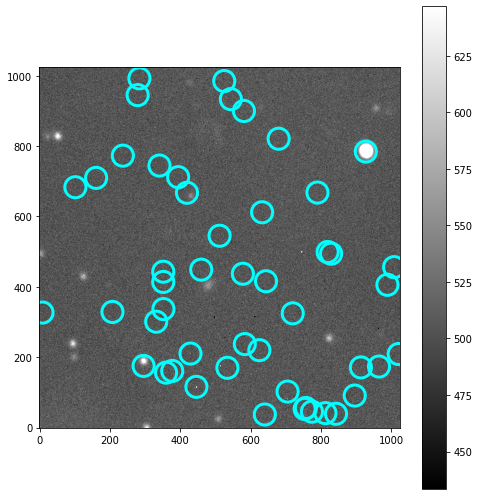

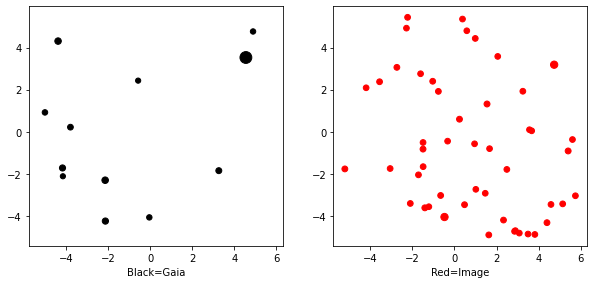

In [24]:
image_name = 'SN2022xzm_1117-003V.fit'
image_ccd = CCDData.read(image_name,unit='adu')

check = plateSolve.autoSolve(image_name,image_ccd,threshold=4, fpnTrim=1024) 
#I increased the starfind threshold to cut down on the number of stars detected
print(image_name,check)



        
#You need to have run autosolve first before 
#you can run the manual commands
#Let's assume the autoSolve failed, which isn't the case here.

#First, plot the image and reference star catalogs
plateSolve.manualSolvePlot(image_name,image_ccd)

In [17]:
for i, fname in image1.ccds(ccd_kwargs = {'unit':'adu'}, return_fname = True):
    if fname.startswith('PG'):
        if check == True:
                plateSolve.cleanup(fname, check = False)

Deleting the following files:
['PG1633p099-001B.wcs', 'PG1633p099-001B.gaia.proj.plate', 'PG1633p099-001B.gaia.csv', 'PG1633p099-001B.match.csv', 'PG1633p099-001B.gaia.proj', 'PG1633p099-001B.stars.csv', 'PG1633p099-001B.match.transform']
Deleting the following files:
[]
Deleting the following files:
[]


In [21]:
gaia_list = [0,2,1,6]
image_list = [1,9,22,14]

check = plateSolve.manualSolve(image_name,image_ccd,gaia_list,image_list)
print("Check is True if successful")
print(image_name,check)

Check is True if successful
SN2022xzm_1117-001R.fit True
